In [1]:
import os
from tqdm.auto import tqdm
import shutil as sh

from PIL import Image, ImageDraw

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import cv2
import torch

YOLO_PATH = "/home/mohamed-ali/Downloads/yolov5/runs/train/cheque_yolov5s8/weights/best.pt"

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
weights_path = {"YOLO":YOLO_PATH}

### Torch hub deployment API Inspiration

In [3]:
class ChequeDetection:
    
    """
    Class implements Yolo5 model to make inferences on a banque cheque.
    """
    
    def __init__(self, image_url, out_file, weights_path):
        """
        Initializes the class with youtube url and output file.
        :param url: Has to be as URL image,on which prediction is made.
        :param out_file: A valid output file name.
        :param weights_path: Dict of models weight paths
        """
        self._URL = image_url
        #self.model = self.load_model(model_name=) # Load model weights
        #self.classes = self.model.names # Classes name
        self.out_file = out_file # Output file directory
        self.weights_path = weights_path
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # Device 
        print("\n\nDevice Used:",self.device)
        
    def get_image_from_url(self):
        """
        Creates a new image object to extract fields from it using yolov5.
        :return: opencv2 image.
        """
        
        assert self.image_url is not None
        return cv2.imread(self.image_url)
    
    def load_model(self, model_name):
        """
        Loads DNN model from weights path.
        :return: Trained Pytorch model.
        """
        
        if self.weights_path[model_name] == "YOLO":
            model = torch.hub.load('ultralytics/yolov5', "custom", path="/home/mohamed-ali/Downloads/yolov5/runs/train/essaie12/weights/best.pt", force_reload=True)
        return model
    
    
    def score_frame(self, img):
        """
        Takes a single img as input, and scores the img using yolo5 model.
        :param img: input frame in numpy/list/tuple format.
        :return: Labels and Coordinates of objects detected by model in the frame.
        """
        self.model.to(self.device)
        frame = [frame]
        results = self.model(img)
     
        confidence, cord = results.xyxyn[0][:, -3], results.xyxyn[0][:, :-1]
        return confidence, cord
    
    
    def draw_boxes(img, results):
        """
        Takes an image and its results as input, and plots the bounding boxes and label on to the image.
        :param results: contains labels and coordinates predicted by model on the given img.
        :param img: img which has been scored.
        :return: img with bounding boxes and labels ploted on it.
        """
        labels, cord = results
        n = len(labels)
        x_shape, y_shape = img.shape[1], img.shape[0]
        for i in range(n):
            row = cord[i]
            if row[4] >= 0.2:
                x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
                bgr = (0, 255, 0)
                cv2.rectangle(img, (x1, y1), (x2, y2), bgr, 1)
                torch.set_printoptions(precision=3)
                cv2.putText(img, str(labels[i].item()), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, bgr, 1)
        
        return img


### PILLOW preprocessing for deployment

In [ ]:
import os
import base64
import requests

from io import BytesIO
from PIL import Image, ImageDraw


def draw_box(img, boxes):
    """
    Draw boxes on the picture
    :param img : PIL Image object
    :param boxes : numpy array of size [number_of_boxes, 6]
    :return : PIL Image object with rectangles
    """
    box = ImageDraw.Draw(img)
    for i in range(boxes.shape[0]):
        data = list(boxes[i])
        shape = [data[0], data[1], data[2], data[3]]
        box.rectangle(shape, outline ="#02d5fa", width=3)
    return img


def url_to_img(url):
    """
    Convert Url to PIL Image
    : param url : string with the link to the image
    : return : PIL Image object
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def img_to_bytes(img):
    """
    Convert PIL image to base64
    :param img : PIL Image object
    :return : Image in the form of base64
    """
    buffered = BytesIO()
    img.save(buffered, format=img.format)
    img_str = base64.b64encode(buffered.getvalue())
    return img_str.decode("utf-8")


def bytes_to_img(im_b64):
    """
    Convert base64 to PIL image
    :param im_b64 : base64 image
    :return img : PIL Image object
    :return img_format : String with image format 
    """
    im_bytes = base64.b64decode(im_b64)   # im_bytes is a binary image
    im_file = BytesIO(im_bytes)  # convert image to file-like object
    img = Image.open(im_file)
    img_format = img.format.lower()
    return img, img_format

In [45]:
# Load image using cv2
img_cv2 = cv2.imread("/home/mohamed-ali/Downloads/yolov5/cheque_data/validation/1.jpg")
# Load image using Pillow
img_pillow = Image.open("/home/mohamed-ali/Downloads/yolov5/cheque_data/validation/1.jpg")
# Instantiate model and load weights
if(os.path.isfile('/home/mohamed-ali/models/ultralytics_yolov5_master/hubconf.py')==False):
    torch.hub.set_dir('/home/mohamed-ali/models/')
    model = torch.hub.load('ultralytics/yolov5', "custom", path="/home/mohamed-ali/Downloads/yolov5/runs/train/essaie12/weights/best.pt", force_reload=True)
else:
    model = torch.hub.load('/home/mohamed-ali/models/ultralytics_yolov5_master', "custom",source='local', path="/home/mohamed-ali/Downloads/yolov5/runs/train/essaie12/weights/best.pt", force_reload=True)
# Model to device
model.to(device)
# Non Max Suppression threshold
model.conf = 0.4

YOLOv5 🚀 2022-5-4 torch 1.10.2 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5947MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [46]:
img_url = "/home/mohamed-ali/Downloads/yolov5/cheque_data/validation/1.jpg"
out_dir = "/home/mohamed-ali/Downloads/output_files"

### Results with cv2 image

In [47]:
# Compute prediction (bbox, confidence....)
cv2_results = model(img_cv2, size=512, augment=True)

In [48]:
cv2_results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,18.286804,105.016785,366.717468,128.213974,0.900766,2,montant en lettre2
1,356.524323,136.409241,503.396027,222.898407,0.844499,5,signature
2,366.512909,95.932632,484.780914,123.913452,0.817539,4,montant en chiffre
3,355.201294,12.962753,499.440552,48.139839,0.798310,3,date
4,8.539536,82.247437,368.867126,109.418716,0.783921,1,montant en lettre
5,27.742477,53.121952,403.285217,80.910706,0.449437,0,name


### Results with Pillow image

In [49]:
pil_results = model(img_pillow, size=512, augment=True)

In [50]:
pil_results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,18.286804,105.016785,366.717468,128.213974,0.900766,2,montant en lettre2
1,356.524323,136.409241,503.396027,222.898407,0.844499,5,signature
2,366.512909,95.932632,484.780914,123.913452,0.817539,4,montant en chiffre
3,355.201294,12.962753,499.440552,48.139839,0.798310,3,date
4,8.539536,82.247437,368.867126,109.418716,0.783921,1,montant en lettre
5,27.742477,53.121952,403.285217,80.910706,0.449437,0,name


In [52]:
# Croped images
crops = pil_results.crop(save=True, save_dir=out_dir)

Saved 1 image to /home/mohamed-ali/Downloads/output_files
Saved results to /home/mohamed-ali/Downloads/output_files



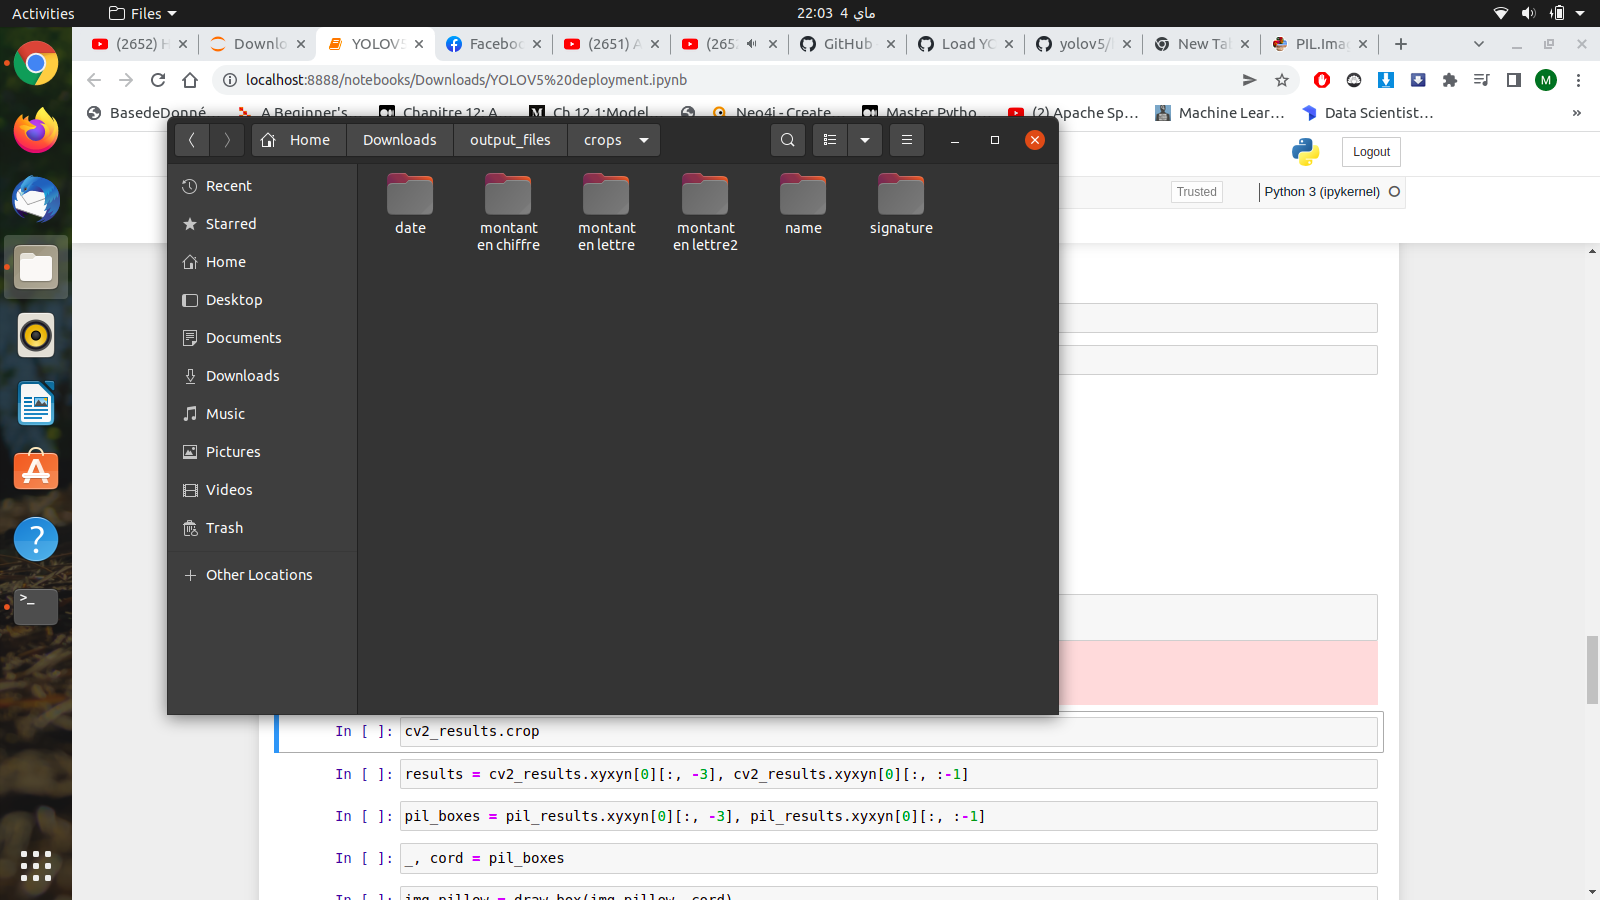